In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [2]:
# Define the paths
data_paths = {
    'Bearing Fault': r'E:\Cutting Tool Paper\Dataset\cutting tool data\cwt images data\Bearing Fault Data',
    'Gear Fault': r'E:\Cutting Tool Paper\Dataset\cutting tool data\cwt images data\Gear Fault Data',
    'Tool Fault': r'E:\Cutting Tool Paper\Dataset\cutting tool data\cwt images data\Tool Fault Data',
    'Normal': r'E:\Cutting Tool Paper\Dataset\cutting tool data\cwt images data\Normal Data',
}

# Function to load images and labels
def load_images_and_labels(data_paths):
    images = []
    labels = []
    for label, path in data_paths.items():
        for file in os.listdir(path):
            img_path = os.path.join(path, file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
            img = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(data_paths)
print(len(images))
print(len(labels))


320
320


In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# One-hot encode the labels
labels_one_hot = tf.keras.utils.to_categorical(labels_encoded)


In [4]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:


# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)


In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout

# Load the VGG16 model without the top layer (Corrected input_shape)
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

# Freeze the layers of VGG16
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
input_layer = Input(shape=(224, 224, 3))  # Corrected input_shape
x = vgg_base(input_layer)
x = Flatten()(x)
cnn_feature_model = Model(inputs=input_layer, outputs=x)

# Extract features for the training and validation sets
X_train_features = cnn_feature_model.predict(X_train)
X_val_features = cnn_feature_model.predict(X_val)


8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


In [8]:
# Reshape the features to fit LSTM input requirements
X_train_features = X_train_features.reshape(X_train_features.shape[0], 1, X_train_features.shape[1])
X_val_features = X_val_features.reshape(X_val_features.shape[0], 1, X_val_features.shape[1])


In [9]:
X_train.shape, X_val.shape

((256, 224, 224, 3), (64, 224, 224, 3))

In [10]:
from tensorflow.keras.layers import LSTM

# Define the LSTM model
lstm_input = Input(shape=(1, X_train_features.shape[2]))
x = LSTM(128)(lstm_input)
lstm_feature_model = Model(inputs=lstm_input, outputs=x)

# Extract temporal features
X_train_lstm_features = lstm_feature_model.predict(X_train_features)
X_val_lstm_features = lstm_feature_model.predict(X_val_features)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [11]:
from deap import base, creator, tools, algorithms
import random

# Define evaluation function
def evaluate(individual):
    selected_features = [i for i in range(len(individual)) if individual[i] == 1]
    if len(selected_features) == 0:
        return 0,
    
    X_train_selected = X_train_lstm_features[:, selected_features]
    X_val_selected = X_val_lstm_features[:, selected_features]
    
    model = tf.keras.Sequential([
        Dense(64, activation='relu', input_dim=len(selected_features)),
        Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_selected, y_train, epochs=10, batch_size=8, verbose=0)
    
    _, accuracy = model.evaluate(X_val_selected, y_val, verbose=0)
    return accuracy,

# Define GA components
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train_lstm_features.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# GA execution
population = toolbox.population(n=50)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=2, verbose=True)

# Get the best individual
best_ind = tools.selBest(population, k=1)[0]
selected_features = [i for i in range(len(best_ind)) if best_ind[i] == 1]


C:\Users\Muhammad Umar\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


gen	nevals
0  	50    
1  	31    
2  	34    


In [12]:
# Select the features based on GA
X_train_selected = X_train_lstm_features[:, selected_features]
X_val_selected = X_val_lstm_features[:, selected_features]

# Define the final classification model
final_model = tf.keras.Sequential([
    Dense(64, activation='relu', input_dim=len(selected_features)),
    Dense(4, activation='softmax')
])

final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the final model
history = final_model.fit(X_train_selected, y_train, epochs=50, batch_size=8, validation_data=(X_val_selected, y_val))


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4098 - loss: 1.3488 - val_accuracy: 0.4688 - val_loss: 1.2298
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5468 - loss: 1.1593 - val_accuracy: 0.3750 - val_loss: 1.1399
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5741 - loss: 1.0625 - val_accuracy: 0.3281 - val_loss: 1.0755
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4855 - loss: 1.0259 - val_accuracy: 0.3750 - val_loss: 1.0277
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6524 - loss: 0.9007 - val_accuracy: 0.4062 - val_loss: 1.0027
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6030 - loss: 0.8649 - val_accuracy: 0.4375 - val_loss: 0.9653
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6324 - loss: 0.8326 - val_accuracy: 0.4062 - val_loss: 0.9557
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6465 - loss: 0.7932 - val_accuracy: 0.4219 - val_loss:

In [13]:
# Evaluate the model on the validation set
val_loss, val_accuracy = final_model.evaluate(X_val_selected, y_val)
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5000 - loss: 0.9496  
Validation Accuracy: 50.00%


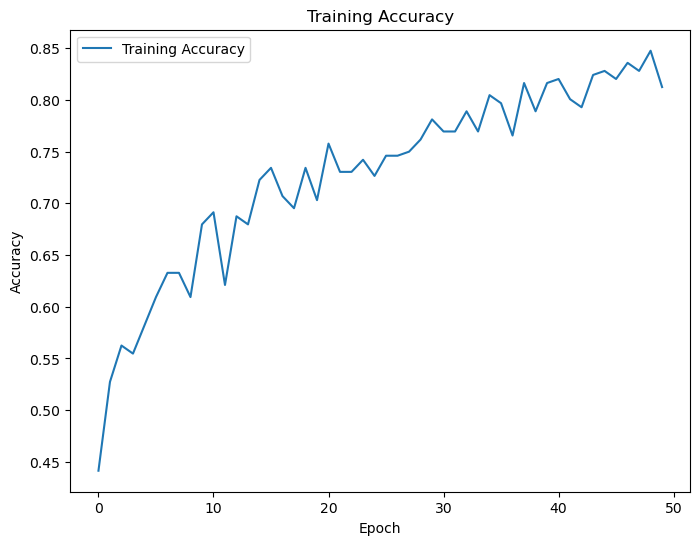

In [14]:
import matplotlib.pyplot as plt

# Get training accuracy values
acc = history.history['accuracy']

# Plot training accuracy
plt.figure(figsize=(8, 6))
plt.plot(acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


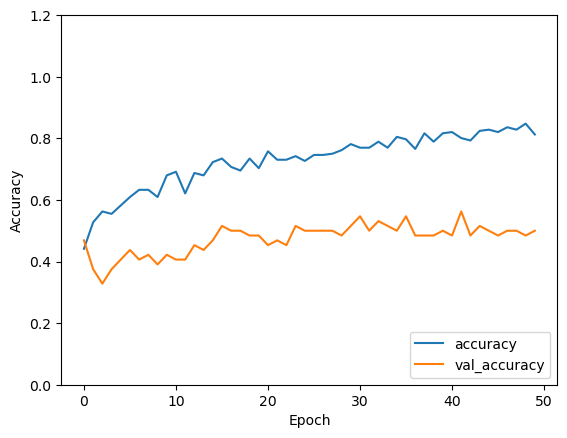

In [15]:
# Plot and save accuracy
plt.plot(history.epoch,history.history['accuracy'], label='accuracy')
plt.plot(history.epoch,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.2])
plt.legend(loc='lower right') 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step


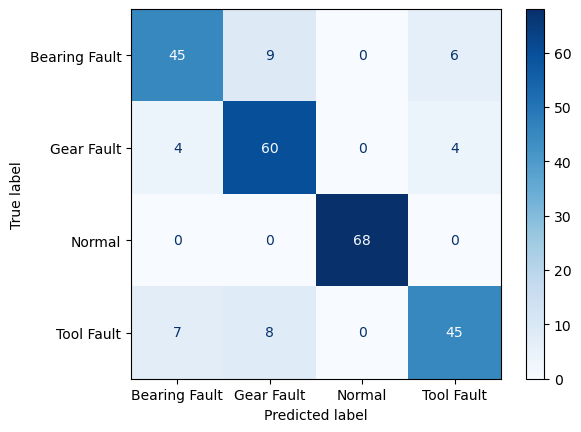

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for the training data
y_train_pred = final_model.predict(X_train_selected)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_train_true_classes, y_train_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
#plt.title('Confusion Matrix - Training Data')
plt.show()


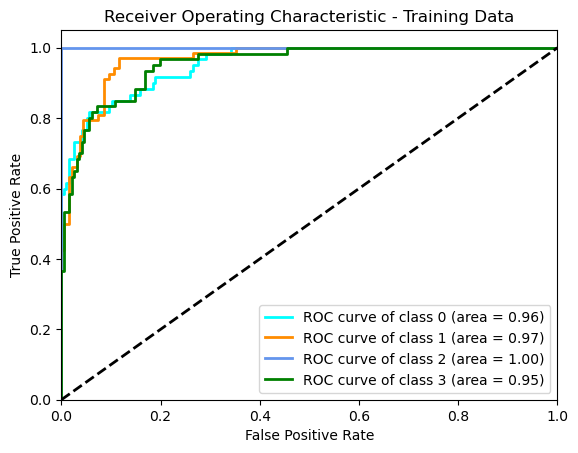

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
y_train_binarized = label_binarize(y_train_true_classes, classes=[0, 1, 2, 3])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_train.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_train_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Training Data')
plt.legend(loc="lower right")
plt.show()


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step


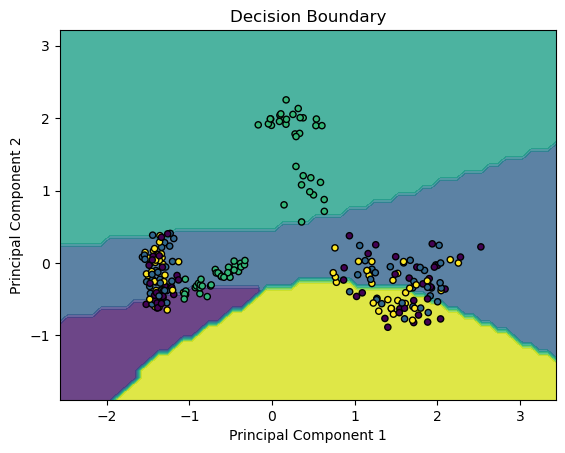

In [18]:
from sklearn.decomposition import PCA

# Reduce features to 2D using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_selected)

# Plot decision boundaries
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Create a mesh to plot points in
Z = final_model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_true_classes, edgecolor='k', s=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary')
plt.show()


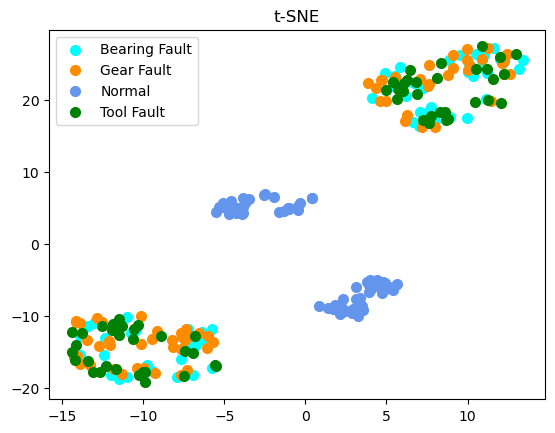

In [19]:
from sklearn.manifold import TSNE

# Reduce features to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_selected)

# Plot t-SNE
plt.figure()
for i, color, label in zip(range(n_classes), colors, label_encoder.classes_):
    plt.scatter(X_train_tsne[y_train_true_classes == i, 0], X_train_tsne[y_train_true_classes == i, 1], color=color, lw=2, label=label)
plt.title('t-SNE')
plt.legend(loc='best')
plt.show()


In [20]:
from collections import Counter
print(Counter(labels))


Counter({'Bearing Fault': 80, 'Gear Fault': 80, 'Tool Fault': 80, 'Normal': 80})


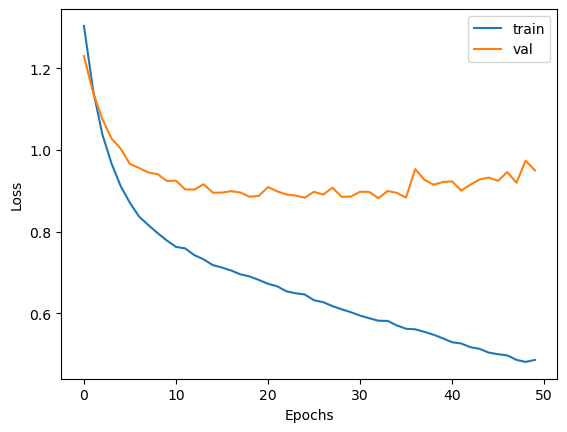

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [22]:
import os
import numpy as np
import tensorflow as tf

# Function to load images and labels from a given directory
def load_unseen_images(data_path):
    images = []
    filenames = []
    for file in os.listdir(data_path):
        img_path = os.path.join(data_path, file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img)
        filenames.append(file)
    return np.array(images), filenames

# Path to the unseen data
unseen_data_path = r'E:\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images\BF\channel1'
unseen_images, filenames = load_unseen_images(unseen_data_path)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:\\Cutting Tool Paper\\Dataset\\cutting tool data\\test_data_40_images\\BF\\channel1'

In [ ]:
# Normalize the images (if the training data was normalized)
unseen_images = unseen_images / 255.0


In [ ]:
# Extract features using the trained CNN model
unseen_features = cnn_feature_model.predict(unseen_images)
unseen_features = unseen_features.reshape(unseen_features.shape[0], 1, unseen_features.shape[1])

# Extract temporal features using the trained LSTM model
unseen_lstm_features = lstm_feature_model.predict(unseen_features)


In [ ]:
# Select the features based on the trained GA
unseen_selected_features = unseen_lstm_features[:, selected_features]


In [23]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Function to load a single image and its filename
def load_single_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

# Path to the single image
single_image_path = r'E:\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images\BF\channel1\Sample_1.png'  # Replace with your actual path

# Load the single image
single_image = load_single_image(single_image_path)

# Normalize the image (if the training data was normalized)
single_image = single_image / 255.0

# Extract features using the trained CNN model
single_image_features = cnn_feature_model.predict(single_image)
single_image_features = single_image_features.reshape(1, 1, single_image_features.shape[1])

# Extract temporal features using the trained LSTM model
single_image_lstm_features = lstm_feature_model.predict(single_image_features)

# Select the features based on the trained GA
single_image_selected_features = single_image_lstm_features[:, selected_features]

# Predict the class for the single image
single_image_prediction = final_model.predict(single_image_selected_features)
single_image_pred_class = np.argmax(single_image_prediction, axis=1)[0]

# Decode the prediction to class label
predicted_label = label_encoder.inverse_transform([single_image_pred_class])[0]

# Print the result for the single image
print(f'File: {os.path.basename(single_image_path)}, Predicted Class: {predicted_label}')


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Cutting Tool Paper\\Dataset\\cutting tool data\\test_data_40_images\\BF\\channel1\\Sample_1.png'

In [ ]:
# Predict the classes for the unseen data
unseen_predictions = final_model.predict(unseen_selected_features)
unseen_pred_classes = np.argmax(unseen_predictions, axis=1)

# Print the results
for filename, pred_class in zip(filenames, unseen_pred_classes):
    print(f'File: {filename}, Predicted Class: {label_encoder.inverse_transform([pred_class])[0]}')
